# MHKiT Quality Control Module
The following example runs a simple quality control analysis on wave elevation data using the [MHKiT QC module](https://mhkit-software.github.io/MHKiT/mhkit-python/api.qc.html).  The data file used in this example is stored in the [\\\\MHKiT\\\\examples\\\\data](https://github.com/MHKiT-Software/MHKiT-Python/tree/master/examples/data) directory.

Start by importing the necessary Python packages and MHKiT modules.

In [1]:
import pandas as pd
from mhkit import qc, utils

## Load Data

The wave elevation data used in this example includes several issues, including timestamps that are out of order, corrupt data with values of -999, data outside the expected range, and stagnant data.  

The data is loaded into a pandas DataFrame using the pandas method `read_csv`.  The first 5 rows of data are shown below, along with a plot.

        probe1  probe2  probe3
Time                          
10.000   24.48   28.27     1.3
10.002   34.48   40.27    -8.7
10.004   30.48   38.27   -13.7
10.006   12.48   24.27   -32.7
10.008   13.48   22.27   -21.7


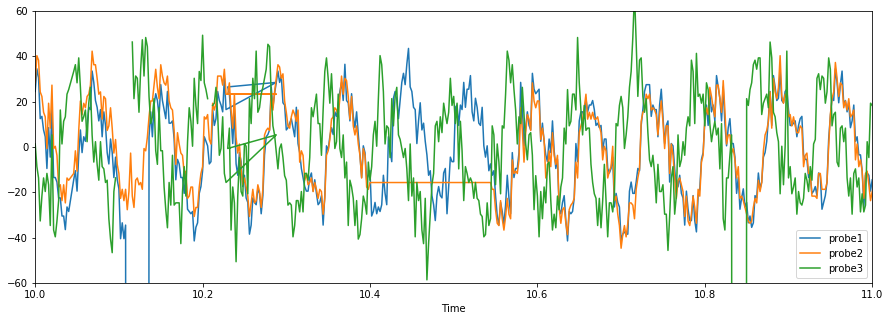

In [2]:
# Load data from the csv file into a DataFrame
data = pd.read_csv('data/wave_elevation_data.csv', index_col='Time') 

# Plot the data
data.plot(figsize=(15,5), ylim=(-60,60)) 

# Print the first 5 rows of data
print(data.head()) 

The data is indexed by time in seconds. To use the quality control functions, the data must be indexed by datetime.  The index can be converted to datetime using the following utility function.

In [3]:
# Convert the index to datetime
data.index = utils.index_to_datetime(data.index, origin='2019-05-20') 

# Print the first 5 rows of data
print(data.head())

                         probe1  probe2  probe3
Time                                           
2019-05-20 00:00:10.000   24.48   28.27     1.3
2019-05-20 00:00:10.002   34.48   40.27    -8.7
2019-05-20 00:00:10.004   30.48   38.27   -13.7
2019-05-20 00:00:10.006   12.48   24.27   -32.7
2019-05-20 00:00:10.008   13.48   22.27   -21.7


## Quality control tests
The following quality control tests are used to identify timestamp issues, corrupt data, data outside the expected range, and stagnant data.

Each quality control tests results in the following information:

* Cleaned data, which is a DataFrame that has *NaN* in place of data that did not pass the quality control test
* Boolean mask, which is a DataFrame with True/False that indicates if each data point passed the quality control test
* Summary of the quality control test results, the summary includes the variable name (which is blank for timestamp issues), the start and end time of the test failure, and an error flag for each test failure

### Check timestamp
Quality control analysis generally starts by checking the timestamp index of the data.  

The following test checks to see if 1) the data contains duplicate timestamps, 2) timestamps are not monotonically increasing, and 3) timestamps occur at irregular intervals (an interval of 0.002s is expected for this data). 

If duplicate timestamps are found, the resulting DataFrames (cleaned data and mask) keep the first occurrence. If timestamps are not monotonic, the timestamps in the resulting DataFrames are reordered.

In [4]:
# Define expected frequency of the data, in seconds
frequency = 0.002 

# Run the timestamp quality control test
results = qc.check_timestamp(data, frequency) 

The cleaned data, boolean mask, and test results summary are shown below. The summary is transposed (using .T) so that it is easier to read.

                         probe1  probe2  probe3
2019-05-20 00:00:10.000   24.48   28.27     1.3
2019-05-20 00:00:10.002   34.48   40.27    -8.7
2019-05-20 00:00:10.004   30.48   38.27   -13.7
2019-05-20 00:00:10.006   12.48   24.27   -32.7
2019-05-20 00:00:10.008   13.48   22.27   -21.7


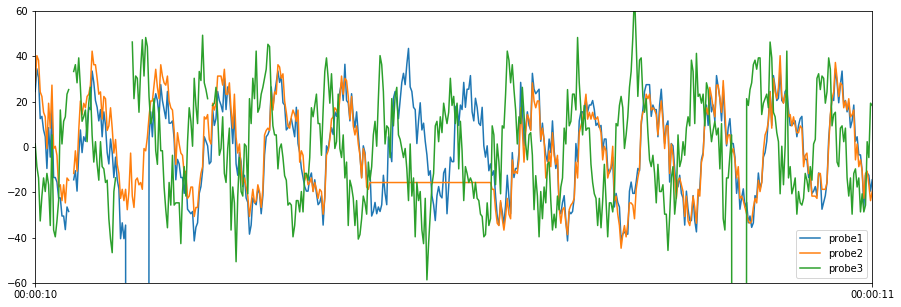

In [5]:
# Plot cleaned data
results['cleaned_data'].plot(figsize=(15,5), ylim=(-60,60)) 

# Print the first 5 rows of the cleaned data
print(results['cleaned_data'].head()) 

In [6]:
# Print the first 5 rows of the mask
print(results['mask'].head()) 

                         probe1  probe2  probe3
2019-05-20 00:00:10.000    True    True    True
2019-05-20 00:00:10.002    True    True    True
2019-05-20 00:00:10.004    True    True    True
2019-05-20 00:00:10.006    True    True    True
2019-05-20 00:00:10.008    True    True    True


In [7]:
# Print the test results summary, the summary is transposed (using .T) so that it is easier to read.
print(results['test_results'].T) 

                                        0                           1  \
Variable Name                                                           
Start Time     2019-05-20 00:00:10.230000  2019-05-20 00:00:10.340000   
End Time       2019-05-20 00:00:10.230000  2019-05-20 00:00:10.340000   
Timesteps                               1                           1   
Error Flag         Nonmonotonic timestamp         Duplicate timestamp   

                                        2  
Variable Name                              
Start Time     2019-05-20 00:00:10.042000  
End Time       2019-05-20 00:00:10.044000  
Timesteps                               2  
Error Flag              Missing timestamp  


### Check for corrupt data
In the following quality control tests, the cleaned data from the previous test is used as input to the subsequent test. For each quality control test, a plot of the cleaned data is shown along with the test results summary.

Note, that if you want to run a series of quality control tests before extracting the cumulative cleaned data, boolean mask, and summary, we recommend using Pecos directly with the object-oriented approach, see https://pecos.readthedocs.io/ for more details.

The quality control test below checks for corrupt data, indicated by a value of -999.

                                        0                           1
Variable Name                      probe1                      probe3
Start Time     2019-05-20 00:00:10.110000  2019-05-20 00:00:10.834000
End Time       2019-05-20 00:00:10.134000  2019-05-20 00:00:10.848000
Timesteps                              13                           8
Error Flag                   Corrupt data                Corrupt data


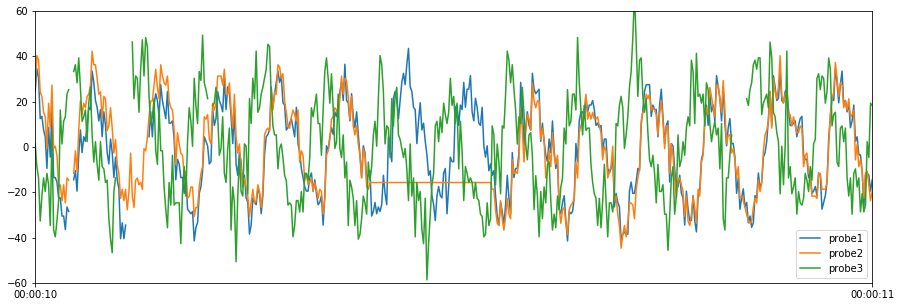

In [8]:
# Define corrupt values
corrupt_values = [-999] 

# Run the corrupt data quality control test
results = qc.check_corrupt(results['cleaned_data'], corrupt_values) 

# Plot cleaned data
results['cleaned_data'].plot(figsize=(15,5), ylim=(-60,60)) 

# Print test results summary
print(results['test_results'].T)

### Check for data outside the expected range
The next quality control test checks for data that is greater than 50 or less than -50. Note that expected range tests can also be used to compare measured values to a model, or analyze the expected relationships between data columns.

                                        0                           1  \
Variable Name                      probe3                      probe3   
Start Time     2019-05-20 00:00:10.240000  2019-05-20 00:00:10.468000   
End Time       2019-05-20 00:00:10.240000  2019-05-20 00:00:10.468000   
Timesteps                               1                           1   
Error Flag        Data < lower bound, -50     Data < lower bound, -50   

                                        2  
Variable Name                      probe3  
Start Time     2019-05-20 00:00:10.716000  
End Time       2019-05-20 00:00:10.716000  
Timesteps                               1  
Error Flag         Data > upper bound, 50  


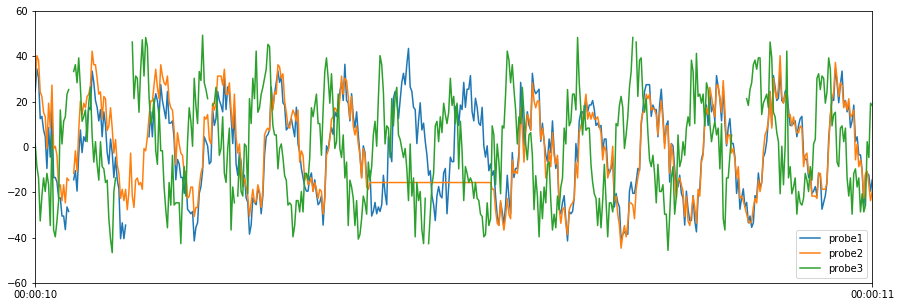

In [9]:
# Define expected lower and upper bound ([lower bound, upper bound])
expected_bounds = [-50, 50] 

# Run expected range quality control test
results = qc.check_range(results['cleaned_data'], expected_bounds) 

# Plot cleaned data
results['cleaned_data'].plot(figsize=(15,5), ylim=(-60,60)) 

# Print test results summary
print(results['test_results'].T) 

### Check for stagnant data
The final quality control test checks for stagnant data by looking for data that changes by less than 0.001 within a 0.02 second moving window. 

                                        0
Variable Name                      probe2
Start Time     2019-05-20 00:00:10.400000
End Time       2019-05-20 00:00:10.544000
Timesteps                              73
Error Flag     Delta < lower bound, 0.001


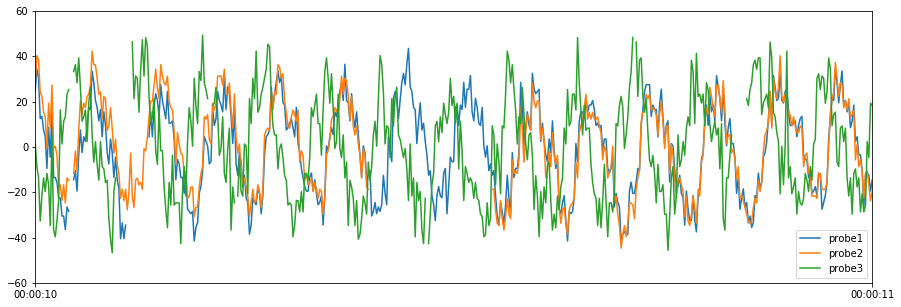

In [10]:
# Define expected lower bound (no upper bound is specified in this example)
expected_bound = [0.001, None] 

# Define the moving window, in seconds
window = 0.02 

# Run the delta quality control test
results = qc.check_delta(results['cleaned_data'], expected_bound, window=window) 

# Plot cleaned data
results['cleaned_data'].plot(figsize=(15,5), ylim=(-60,60))

# Print test results summary
print(results['test_results'].T) 

## Cleaned Data
The cleaned data can be used directly in MHKiT analysis, or the missing values can be replaced using various methods before analysis is run. 
Data replacement strategies are generally defined on a case by case basis. Pandas includes methods to interpolate, replace, and fill missing values.

In [11]:
# Extract final cleaned data for MHKiT analysis
cleaned_data = results['cleaned_data'] 